<a href="https://www.kaggle.com/code/sathulakjan/amex-prediction-new?scriptVersionId=117016352" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualize the data
import seaborn as sns # visualize the data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle 
import lightgbm as lgb

import warnings

warnings.simplefilter('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
%matplotlib inline

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr
/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet


# Load data

In [4]:
df_train = pd.read_feather('/kaggle/input/amexfeather/train_data.ftr')
df_train.drop(['target'], axis = 1, inplace = True)
df_train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983


In [5]:
df_test = pd.read_feather('/kaggle/input/amexfeather/test_data.ftr')
df_test

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614746,0.009064,0.021667,0.816406,0.009720,0.188965,0.004124,0.015327,...,NaN,NaN,NaN,0.004742,0.006393,0.002890,NaN,0.006042,0.005207,0.007858
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591797,0.238770,0.015930,0.810547,0.002026,0.180054,0.000731,0.011284,...,NaN,NaN,NaN,0.008133,0.004330,0.008385,NaN,0.001008,0.007420,0.009468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363757,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2018-12-19,0.440918,0.000144,0.008636,0.818359,0.001797,NaN,0.006420,0.002710,...,NaN,NaN,NaN,0.006512,0.008873,0.001236,NaN,0.009659,0.005520,0.001351
11363758,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-01-19,0.445557,0.006832,0.009636,0.815430,0.009872,NaN,0.003611,0.006920,...,NaN,NaN,NaN,0.003374,0.009003,0.004181,NaN,0.007835,0.000256,0.004917
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.459961,0.005245,0.004421,0.818848,0.000665,NaN,0.000559,0.007057,...,NaN,NaN,NaN,0.007797,0.007740,0.008194,NaN,0.009384,0.003593,0.005604
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970


In [6]:
target = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
target

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1


# EDA

In [7]:
print(df_train.shape)
print(df_test.shape)
print(target.shape)

(5531451, 190)
(11363762, 190)
(458913, 2)


In [8]:
df_train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983


In [9]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [10]:
df_train.select_dtypes(include = ['object', 'category']).columns

Index(['customer_ID', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114',
       'D_116', 'D_117', 'D_120', 'D_126'],
      dtype='object')

In [11]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
num_cols = []
for col in df_train.columns:
    if col not in categorical_cols+['customer_ID','S_2']:
        num_cols.append(col)

num_cols = np.array(num_cols)
print("categorical cols: ", categorical_cols)
print("numerical cols: ", num_cols)

categorical cols:  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
numerical cols:  ['P_2' 'D_39' 'B_1' 'B_2' 'R_1' 'S_3' 'D_41' 'B_3' 'D_42' 'D_43' 'D_44'
 'B_4' 'D_45' 'B_5' 'R_2' 'D_46' 'D_47' 'D_48' 'D_49' 'B_6' 'B_7' 'B_8'
 'D_50' 'D_51' 'B_9' 'R_3' 'D_52' 'P_3' 'B_10' 'D_53' 'S_5' 'B_11' 'S_6'
 'D_54' 'R_4' 'S_7' 'B_12' 'S_8' 'D_55' 'D_56' 'B_13' 'R_5' 'D_58' 'S_9'
 'B_14' 'D_59' 'D_60' 'D_61' 'B_15' 'S_11' 'D_62' 'D_65' 'B_16' 'B_17'
 'B_18' 'B_19' 'B_20' 'S_12' 'R_6' 'S_13' 'B_21' 'D_69' 'B_22' 'D_70'
 'D_71' 'D_72' 'S_15' 'B_23' 'D_73' 'P_4' 'D_74' 'D_75' 'D_76' 'B_24'
 'R_7' 'D_77' 'B_25' 'B_26' 'D_78' 'D_79' 'R_8' 'R_9' 'S_16' 'D_80' 'R_10'
 'R_11' 'B_27' 'D_81' 'D_82' 'S_17' 'R_12' 'B_28' 'R_13' 'D_83' 'R_14'
 'R_15' 'D_84' 'R_16' 'B_29' 'S_18' 'D_86' 'D_87' 'R_17' 'R_18' 'D_88'
 'B_31' 'S_19' 'R_19' 'B_32' 'S_20' 'R_20' 'R_21' 'B_33' 'D_89' 'R_22'
 'R_23' 'D_91' 'D_92' 'D_93' 'D_94' 'R_24' 'R_25' 'D_96' 'S_22' 'S_23'
 'S_24' 'S

In [12]:
df_train[categorical_cols]

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...
5531446,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0
5531447,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0
5531448,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0
5531449,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CL,O,NaN,5.0


In [13]:
def denoise(df):
    df['D_63'] = df['D_63'].apply(lambda t: {'CR': 0, 'XZ': 1, 'XM': 2, 'CO': 3, 'CL': 4, 'XL': 5}[t]).astype(np.int8)
    df['D_64'] = df['D_64'].apply(lambda t: {'O': 0, 'U': 3, 'R': 2, '': -1, '-1': 1}[t]).astype(np.int8)

    return df

def variance(df):
    df_temp = df.drop(['customer_ID','S_2'], axis=1)

    var_thres = VarianceThreshold(threshold = 0)
    var_thres.fit(df_temp)

    constant_columns = [column for column in df_temp.columns if column not in df_temp.columns[var_thres.get_support()]]

    df.drop(constant_columns, axis=1, inplace = True)
    
    return df

def null_details(threshold : np.int8 = 50, cols: np.ndarray = df_train.columns, df: pd.DataFrame = df_train) -> pd.DataFrame:
    null_cols = df[cols].isnull().sum().sort_values()
    df_null = pd.DataFrame(null_cols[null_cols > 0])
    df_null[1] = df[cols].isnull().mean()*100

    return df_null[df_null[1] > threshold]

def remove_cols(df):
    return null_details(80, df.columns).index

def select_best_indeces(group: pd.DataFrame):
    return group.isnull().sum(axis = 1).sort_values().head(1).index[0]

def select_rows(df_grouped):
    return df_grouped.apply(select_best_indeces).values

def one_hot_encoding(df, cols, is_drop = True):
    for col in cols:
        print('one hot encoding:', col)
        dummies = pd.get_dummies(pd.Series(df[col]), prefix =' oneHot_%s'%col, drop_first = True)
        df = pd.concat([df, dummies], axis = 1)
    if is_drop:
        df.drop(cols, axis = 1, inplace = True)
        
    return df

def ordinal_encoding(df, cols):
    enc = OrdinalEncoder()
    df[cols] = enc.fit_transform(df[cols])
    
    return df

In [14]:
null_details(0, categorical_cols)

,0,1
B_30,2016,0.036446
B_38,2016,0.036446
D_126,116816,2.111851
D_114,176716,3.194749
D_116,176716,3.194749
D_117,176716,3.194749
D_120,176716,3.194749
D_68,216503,3.914036
D_66,4908097,88.730733


In [15]:
# pd.set_option('display.max_rows', None)
null_details(0, num_cols)

,0,1
R_7,1,0.000018
R_14,1,0.000018
B_40,53,0.000958
B_37,56,0.001012
R_12,56,0.001012
...,...,...
D_111,5500117,99.433530
D_110,5500117,99.433530
D_108,5502513,99.476846
D_88,5525447,99.891457


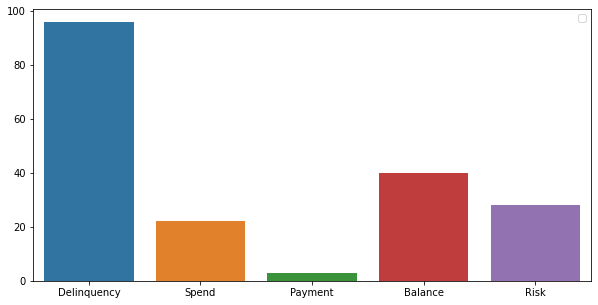

In [16]:
D_cols = df_train.columns[pd.Series(df_train.columns).str.startswith('D_')]
B_cols = df_train.columns[pd.Series(df_train.columns).str.startswith('B_')]
S_cols = df_train.columns[pd.Series(df_train.columns).str.startswith('S_')]
R_cols = df_train.columns[pd.Series(df_train.columns).str.startswith('R_')]
P_cols = df_train.columns[pd.Series(df_train.columns).str.startswith('P_')]

Dict = {'Delinquency': len(D_cols), 'Spend': len(S_cols), 'Payment': len(P_cols), 'Balance': len(B_cols), 'Risk': len(R_cols),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));
plt.legend()

In [17]:
grouped_df = df_train.dropna(how='all').groupby("customer_ID")

In [18]:
selected_indices = select_rows(grouped_df)

In [19]:
df_train = df_train.loc[selected_indices, :]
df_train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937500,0.002424,0.019836,1.008789,0.000607,0.102966,0.006172,0.007454,...,NaN,NaN,NaN,0.001563,0.001976,0.002569,NaN,0.001099,0.006348,0.004204
19,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-09-15,0.904785,0.004154,0.011299,1.006836,0.007053,0.122437,0.007793,0.005417,...,NaN,NaN,NaN,0.000850,0.008133,0.006668,NaN,0.000411,0.006195,0.000796
31,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2017-08-12,0.902344,0.005367,0.003351,0.812012,0.004009,NaN,0.008728,0.006271,...,NaN,NaN,NaN,0.000371,0.005390,0.000652,NaN,0.002085,0.008759,0.006931
40,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-04-21,0.568359,0.001641,0.083252,0.819824,0.006592,0.228149,0.005512,0.002281,...,NaN,NaN,NaN,0.007133,0.009735,0.006760,NaN,0.009193,0.002682,0.009766
52,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2017-03-30,0.937012,0.006573,0.003433,0.818848,0.007244,0.166138,0.008263,0.005928,...,NaN,NaN,NaN,0.005737,0.008316,0.005421,NaN,0.005547,0.003866,0.001375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531386,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2017-03-20,0.859863,0.097717,0.006084,1.000977,0.009377,0.106506,0.008499,0.007881,...,NaN,NaN,NaN,0.009987,0.005863,0.000090,NaN,0.001687,0.009155,0.004055
5531399,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2017-03-22,0.863281,0.007328,0.431396,0.030640,0.004704,0.324951,0.004150,0.303467,...,NaN,NaN,NaN,0.000278,0.000167,0.000416,NaN,0.000305,0.004059,0.005169
5531412,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2017-03-16,0.793945,0.536133,0.063904,1.008789,0.007622,0.084045,0.252686,0.003012,...,NaN,NaN,NaN,0.008736,0.001692,0.005871,NaN,0.009094,0.004574,0.001100
5531437,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,...,NaN,NaN,NaN,1.009766,0.004478,0.949707,0.446289,1.009766,0.002502,0.185547


In [20]:
df_train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,456246.000000,4.589130e+05,458913.000000,458882.000000,458913.000000,400440.000000,458882.000000,4.588820e+05,99734.000000,3.416710e+05,...,3.435600e+04,34356.000000,34356.000000,4.563470e+05,458896.000000,456347.000000,83699.000000,456347.000000,458890.000000,456347.000000
mean,NaN,NaN,0.132324,NaN,0.098999,NaN,0.061676,1.268311e-01,0.178589,1.632080e-01,...,2.138672e-01,0.021286,0.167847,NaN,0.028168,NaN,0.381592,NaN,0.054382,0.065186
std,0.000000,0.000000e+00,0.218384,0.000000,0.263428,0.000000,0.194946,2.200928e-01,0.236938,2.243652e-01,...,1.885986e-01,0.126831,0.260254,0.000000e+00,0.150635,0.000000,0.236816,0.000000,0.187134,0.197388
min,-0.433838,5.960464e-08,-1.350586,0.000001,0.000000,-0.448242,0.000000,1.192093e-07,-0.000454,8.940697e-07,...,5.960464e-08,0.000001,0.000001,5.960464e-08,0.000000,0.000000,-0.014442,0.000000,0.000000,0.000000
25%,0.461670,4.646301e-03,0.009911,0.086792,0.002962,0.130005,0.002911,5.615234e-03,0.032410,4.357910e-02,...,8.087158e-03,0.002516,0.003593,3.053665e-03,0.002550,0.003046,0.189697,0.003059,0.002773,0.003065
50%,0.672852,9.315491e-03,0.037354,0.813477,0.005909,0.165894,0.005806,1.144409e-02,0.111023,9.399414e-02,...,2.531738e-01,0.005047,0.007187,6.118774e-03,0.005108,0.006126,0.371094,0.006115,0.005535,0.006123
75%,0.855957,2.412109e-01,0.144531,1.002930,0.008865,0.270508,0.008713,1.531982e-01,0.237427,1.947021e-01,...,2.575684e-01,0.007607,0.501953,9.185791e-03,0.007664,0.009193,0.549805,0.009178,0.008301,0.009193
max,1.009766,5.390625e+00,1.324219,1.009766,2.759766,3.582031,6.593750,1.506836e+00,4.187500,9.148438e+00,...,1.759766e+00,1.009766,3.000000,1.009766e+00,1.009766,1.330078,2.216797,1.009766,1.343750,4.820312


In [21]:
null_details(0, df_train.columns, df_train)

,0,1
R_20,1,0.000218
S_23,1,0.000218
D_126,6,0.001307
D_140,17,0.003704
D_102,19,0.004140
...,...,...
B_39,454997,99.146679
D_111,455060,99.160407
D_110,455060,99.160407
D_88,457526,99.697764


In [22]:
df_train = denoise(df_train)

In [23]:
removeble_cols = list(remove_cols(df_train))
removeble_cols.append('S_2')

In [24]:
removeble_cols

['D_142',
 'D_42',
 'D_66',
 'D_76',
 'R_26',
 'D_49',
 'D_132',
 'D_106',
 'B_29',
 'R_9',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'B_42',
 'D_73',
 'B_39',
 'D_111',
 'D_110',
 'D_108',
 'D_88',
 'D_87',
 'S_2']

In [25]:
for col in df_train.iloc[:, 2:].columns:
    if col not in removeble_cols:
        if col in categorical_cols:
            df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
        else:
            df_train[col] = df_train[col].fillna(df_train[col].median())

null_details(0, df_train.columns, df_train)

,0,1
D_42,359179,78.267340
D_142,375214,81.761467
D_49,399313,87.012789
D_132,399314,87.013007
D_106,399402,87.032183
D_66,403155,87.849985
D_76,405250,88.306498
R_26,408130,88.934068
B_29,423302,92.240141
D_134,424557,92.513614


In [26]:
df_train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937500,0.002424,0.019836,1.008789,0.000607,0.102966,0.006172,0.007454,...,NaN,NaN,NaN,0.001563,0.001976,0.002569,NaN,0.001099,0.006348,0.004204
19,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-09-15,0.904785,0.004154,0.011299,1.006836,0.007053,0.122437,0.007793,0.005417,...,NaN,NaN,NaN,0.000850,0.008133,0.006668,NaN,0.000411,0.006195,0.000796
31,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2017-08-12,0.902344,0.005367,0.003351,0.812012,0.004009,0.165894,0.008728,0.006271,...,NaN,NaN,NaN,0.000371,0.005390,0.000652,NaN,0.002085,0.008759,0.006931
40,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-04-21,0.568359,0.001641,0.083252,0.819824,0.006592,0.228149,0.005512,0.002281,...,NaN,NaN,NaN,0.007133,0.009735,0.006760,NaN,0.009193,0.002682,0.009766
52,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2017-03-30,0.937012,0.006573,0.003433,0.818848,0.007244,0.166138,0.008263,0.005928,...,NaN,NaN,NaN,0.005737,0.008316,0.005421,NaN,0.005547,0.003866,0.001375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531386,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2017-03-20,0.859863,0.097717,0.006084,1.000977,0.009377,0.106506,0.008499,0.007881,...,NaN,NaN,NaN,0.009987,0.005863,0.000090,NaN,0.001687,0.009155,0.004055
5531399,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2017-03-22,0.863281,0.007328,0.431396,0.030640,0.004704,0.324951,0.004150,0.303467,...,NaN,NaN,NaN,0.000278,0.000167,0.000416,NaN,0.000305,0.004059,0.005169
5531412,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2017-03-16,0.793945,0.536133,0.063904,1.008789,0.007622,0.084045,0.252686,0.003012,...,NaN,NaN,NaN,0.008736,0.001692,0.005871,NaN,0.009094,0.004574,0.001100
5531437,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-03-23,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,...,NaN,NaN,NaN,1.009766,0.004478,0.949707,0.446289,1.009766,0.002502,0.185547


# EDA on Test Data

In [27]:
nans = null_details(0, df_test.columns, df_test)
print(nans)
print(nans.shape)

              0          1
D_86       1067   0.009389
S_23       1541   0.013561
B_40       2003   0.017626
B_37       2020   0.017776
S_12       2385   0.020988
...         ...        ...
D_111  11247468  98.976624
D_110  11247468  98.976624
D_108  11295987  99.403587
D_88   11352497  99.900869
D_87   11352790  99.903447

[120 rows x 2 columns]
(120, 2)


In [28]:
grouped_df_test = df_test.dropna(how='all').groupby("customer_ID")

In [29]:
rows_indices = select_rows(grouped_df_test)
rows_indices

array([       7,       11,       30, ..., 11363729, 11363743, 11363761])

In [30]:
df_test = df_test.loc[rows_indices, :]
df_test

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
7,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-09-29,0.597168,0.003538,0.017426,1.000977,0.005142,0.157959,0.000985,0.011963,...,NaN,NaN,NaN,0.008728,0.000628,0.002821,NaN,0.004143,0.005733,0.005657
11,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2018-06-27,0.893066,0.005245,0.050354,1.001953,0.007221,0.170654,0.001312,0.002151,...,NaN,NaN,NaN,0.008080,0.001725,0.004463,NaN,0.007637,0.004963,0.002647
30,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,2019-06-15,0.754395,0.038788,0.002535,0.813477,0.005562,0.176636,0.002012,0.006039,...,NaN,NaN,NaN,1.000000,0.000602,0.887207,0.134521,1.002930,0.400146,0.098694
40,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,2018-09-25,0.477783,0.417480,0.295166,0.087219,0.003408,0.281250,0.065918,0.665039,...,NaN,NaN,NaN,1.005859,0.005142,0.908203,0.233643,1.001953,0.501465,0.187744
59,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2019-09-14,0.266113,0.121521,0.509277,0.032745,0.506836,0.163696,0.008141,0.698730,...,NaN,NaN,NaN,0.001838,0.003565,0.001343,NaN,0.001249,0.001662,0.006748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363713,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,2019-03-14,0.645508,0.003948,0.006844,0.818359,0.003040,0.157349,0.004768,0.023941,...,NaN,NaN,NaN,0.004719,0.008820,0.008957,NaN,0.003531,0.007618,0.008873
11363723,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,2019-06-09,0.568359,0.008629,0.025879,1.002930,0.504395,0.801758,0.009949,0.036346,...,NaN,NaN,NaN,0.000682,0.008095,0.004082,NaN,0.009552,0.001212,0.008476
11363729,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,2018-05-12,0.240356,0.091125,0.039246,1.009766,0.009735,0.158691,0.279541,0.025650,...,NaN,NaN,NaN,0.009842,0.007957,0.000286,NaN,0.008797,0.000657,0.000256
11363743,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,2018-06-08,0.544434,0.039246,0.092712,0.154053,0.000427,0.194214,0.004761,0.114197,...,NaN,NaN,NaN,0.003704,0.005421,0.000280,NaN,0.007435,0.003839,0.004131


In [31]:
null_details(0, df_test.columns, df_test)

,0,1
S_12,6,0.000649
B_37,7,0.000757
B_41,7,0.000757
S_26,7,0.000757
B_40,7,0.000757
...,...,...
B_39,911308,98.560167
D_111,912499,98.688976
D_110,912499,98.688976
D_88,921899,99.705609


In [32]:
df_test = denoise(df_test)

In [33]:
for col in df_test.iloc[:, 2:].columns:
    if col not in removeble_cols:
        if col in categorical_cols:
            df_test[col] = df_test[col].fillna(df_test[col].mode()[0])
        else:
            df_test[col] = df_test[col].fillna(df_test[col].median())

null_details(0, df_test.columns, df_test)

,0,1
B_29,561669,60.745862
D_142,756745,81.843804
D_42,757592,81.935409
R_26,768182,83.080743
D_49,784026,84.794310
D_132,784232,84.816590
D_106,784403,84.835084
D_66,813025,87.930622
D_76,823904,89.107213
D_138,860849,93.102904


In [34]:
df_test['D_68'] = pd.Categorical(df_test['D_68'], categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False)

In [35]:
df_test

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
7,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-09-29,0.597168,0.003538,0.017426,1.000977,0.005142,0.157959,0.000985,0.011963,...,NaN,NaN,NaN,0.008728,0.000628,0.002821,NaN,0.004143,0.005733,0.005657
11,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2018-06-27,0.893066,0.005245,0.050354,1.001953,0.007221,0.170654,0.001312,0.002151,...,NaN,NaN,NaN,0.008080,0.001725,0.004463,NaN,0.007637,0.004963,0.002647
30,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,2019-06-15,0.754395,0.038788,0.002535,0.813477,0.005562,0.176636,0.002012,0.006039,...,NaN,NaN,NaN,1.000000,0.000602,0.887207,0.134521,1.002930,0.400146,0.098694
40,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,2018-09-25,0.477783,0.417480,0.295166,0.087219,0.003408,0.281250,0.065918,0.665039,...,NaN,NaN,NaN,1.005859,0.005142,0.908203,0.233643,1.001953,0.501465,0.187744
59,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2019-09-14,0.266113,0.121521,0.509277,0.032745,0.506836,0.163696,0.008141,0.698730,...,NaN,NaN,NaN,0.001838,0.003565,0.001343,NaN,0.001249,0.001662,0.006748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363713,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,2019-03-14,0.645508,0.003948,0.006844,0.818359,0.003040,0.157349,0.004768,0.023941,...,NaN,NaN,NaN,0.004719,0.008820,0.008957,NaN,0.003531,0.007618,0.008873
11363723,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,2019-06-09,0.568359,0.008629,0.025879,1.002930,0.504395,0.801758,0.009949,0.036346,...,NaN,NaN,NaN,0.000682,0.008095,0.004082,NaN,0.009552,0.001212,0.008476
11363729,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,2018-05-12,0.240356,0.091125,0.039246,1.009766,0.009735,0.158691,0.279541,0.025650,...,NaN,NaN,NaN,0.009842,0.007957,0.000286,NaN,0.008797,0.000657,0.000256
11363743,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,2018-06-08,0.544434,0.039246,0.092712,0.154053,0.000427,0.194214,0.004761,0.114197,...,NaN,NaN,NaN,0.003704,0.005421,0.000280,NaN,0.007435,0.003839,0.004131


# Handle Categorical Data

In [36]:
for col in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_68']:
    le = LabelEncoder()
    le.fit(df_train[col])
    print('*****')
    print(col)
    print(le.classes_)
    print(df_test[col].unique())
    print(df_train[col].unique())
    print('*****')
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
df_train[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_68']]

*****
B_30
[0. 1. 2.]
[0.0, 1.0, 2.0]
Categories (3, float64): [0.0, 1.0, 2.0]
[0.0, 1.0, 2.0]
Categories (3, float64): [0.0, 1.0, 2.0]
*****
*****
B_38
[1. 2. 3. 4. 5. 6. 7.]
[2.0, 3.0, 6.0, 7.0, 1.0, 5.0, 4.0]
Categories (7, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
[2.0, 1.0, 3.0, 7.0, 4.0, 5.0, 6.0]
Categories (7, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
*****
*****
D_114
[0. 1.]
[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
[1.0, 0.0]
Categories (2, float64): [0.0, 1.0]
*****
*****
D_116
[0. 1.]
[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
*****
*****
D_117
[-1.  1.  2.  3.  4.  5.  6.]
[-1.0, 3.0, 6.0, 4.0, 2.0, 1.0, 5.0]
Categories (7, float64): [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
[4.0, -1.0, 1.0, 2.0, 6.0, 3.0, 5.0]
Categories (7, float64): [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
*****
*****
D_120
[0. 1.]
[1.0, 0.0]
Categories (2, float64): [0.0, 1.0]
[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
*****
*****
D_126
[-1.  

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_68
11,0,1,1,0,4,0,2,6
19,0,1,1,0,0,0,2,6
31,0,0,1,0,0,0,2,6
40,0,1,1,0,0,0,2,2
52,0,1,1,0,4,0,2,6
...,...,...,...,...,...,...,...,...
5531386,0,1,0,0,4,0,2,6
5531399,1,2,1,0,2,0,2,6
5531412,0,1,1,0,0,0,2,5
5531437,0,2,1,0,2,0,2,3


In [37]:
ct = ColumnTransformer([('oneHot', OneHotEncoder(drop='first'), ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_68'])], remainder = 'passthrough')

In [38]:
train_matrix = ct.fit_transform(df_train)
test_matrix = ct.transform(df_test)

In [39]:
new_features = ct.get_feature_names()

In [40]:
train_matrix.dtype

dtype('O')

In [41]:
df_train = pd.DataFrame(train_matrix, columns = new_features)
df_train.set_index('customer_ID', drop = True, inplace = True)
df_train

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.001563,0.001976,0.002569,NaN,0.001099,0.006348,0.004204
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.00085,0.008133,0.006668,NaN,0.000411,0.006195,0.000796
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.000371,0.00539,0.000652,NaN,0.002085,0.008759,0.006931
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.007133,0.009735,0.00676,NaN,0.009193,0.002682,0.009766
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.005737,0.008316,0.005421,NaN,0.005547,0.003866,0.001375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.009987,0.005863,0.00009,NaN,0.001687,0.009155,0.004055
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.000278,0.000167,0.000416,NaN,0.000305,0.004059,0.005169
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.008736,0.001692,0.005871,NaN,0.009094,0.004574,0.0011


In [42]:
df_test = pd.DataFrame(test_matrix, columns = new_features)
df_test.set_index('customer_ID', drop = True, inplace = True)
df_test

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.008728,0.000628,0.002821,NaN,0.004143,0.005733,0.005657
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.00808,0.001725,0.004463,NaN,0.007637,0.004963,0.002647
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,0.000602,0.887207,0.134521,1.00293,0.400146,0.098694
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.005859,0.005142,0.908203,0.233643,1.001953,0.501465,0.187744
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.001838,0.003565,0.001343,NaN,0.001249,0.001662,0.006748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.004719,0.00882,0.008957,NaN,0.003531,0.007618,0.008873
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.000682,0.008095,0.004082,NaN,0.009552,0.001212,0.008476
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0.009842,0.007957,0.000286,NaN,0.008797,0.000657,0.000256


# Featuture Selection

In [43]:
df_train.loc[:, pd.Series(df_train.columns).str.startswith('oneHot').values] = df_train.loc[:, pd.Series(df_train.columns).str.startswith('oneHot').values].astype('int8')

In [44]:
df_train.loc[:, list(df_train.select_dtypes(include=['object']).columns)] = df_train.loc[:, list(df_train.select_dtypes(include=['object']).columns)].astype('float64')

In [45]:
df_train.dtypes.value_counts()

float64           180
int8               25
datetime64[ns]      1
dtype: int64

In [46]:
cor_matrix = df_train.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
            
col_core

{'B_11',
 'B_13',
 'B_23',
 'B_33',
 'B_37',
 'B_39',
 'D_104',
 'D_110',
 'D_111',
 'D_119',
 'D_132',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

<AxesSubplot:>

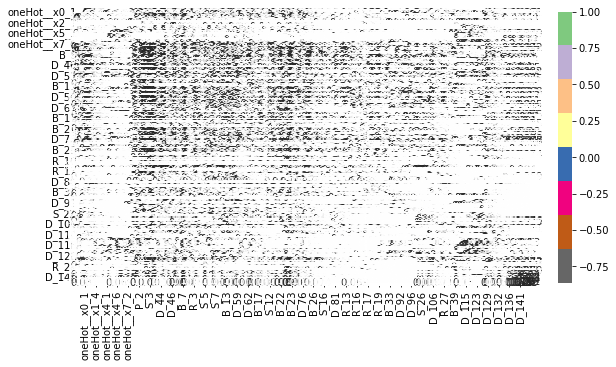

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(cor_matrix, cmap = plt.cm.Accent_r, annot = True)

In [48]:
dropable_cols = np.concatenate((removeble_cols, list(col_core)))
dropable_cols

array(['D_142', 'D_42', 'D_66', 'D_76', 'R_26', 'D_49', 'D_132', 'D_106',
       'B_29', 'R_9', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'B_42',
       'D_73', 'B_39', 'D_111', 'D_110', 'D_108', 'D_88', 'D_87', 'S_2',
       'S_24', 'D_74', 'B_23', 'B_37', 'D_77', 'D_119', 'B_39', 'B_11',
       'B_13', 'B_33', 'D_132', 'D_143', 'S_7', 'D_75', 'D_111', 'D_141',
       'D_110', 'D_104'], dtype='<U5')

In [49]:
df_train.drop(dropable_cols, axis = 1, inplace = True)
df_train

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,0,1,0,0,0,0,0,1,0,...,1.004883,0.006565,0.009850,0.004303,0.000122,0.007725,0.001563,0.001976,0.006348,0.004204
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0,0,1,0,0,0,0,0,1,0,...,0.000041,0.002386,0.000322,0.001282,0.005852,0.009377,0.000850,0.008133,0.006195,0.000796
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0,0,0,0,0,0,0,0,1,0,...,0.003244,0.006149,0.001974,0.005283,0.006134,0.002050,0.000371,0.005390,0.008759,0.006931
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0,0,1,0,0,0,0,0,1,0,...,1.008789,0.001455,0.001575,0.001338,0.005779,0.007858,0.007133,0.009735,0.002682,0.009766
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0,0,1,0,0,0,0,0,1,0,...,1.007812,0.009689,1.007812,0.004456,0.003387,0.002464,0.005737,0.008316,0.003866,0.001375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0,0,1,0,0,0,0,0,0,0,...,0.002077,0.003496,0.005817,0.004726,0.008041,0.004131,0.009987,0.005863,0.009155,0.004055
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,1,0,0,1,0,0,0,0,1,0,...,1.000977,0.000795,1.009766,0.988281,0.751953,0.009804,0.000278,0.000167,0.004059,0.005169
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0,0,1,0,0,0,0,0,1,0,...,1.000977,0.000377,0.005169,0.002649,0.004265,0.000672,0.008736,0.001692,0.004574,0.001100


In [50]:
df_test.drop(dropable_cols, axis = 1, inplace = True)
df_test

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00988,0.002392,0.002426,0.000243,0.003626,0.006531,0.008728,0.000628,0.005733,0.005657
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.007198,0.000154,0.007534,0.007927,0.000696,0.009781,0.00808,0.001725,0.004963,0.002647
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007881,0.002945,1.00293,0.00758,0.005718,0.004383,1.0,0.000602,0.400146,0.098694
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007626,0.008354,0.004047,0.001248,0.005379,0.008217,1.005859,0.005142,0.501465,0.187744
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.003906,0.008919,0.008797,0.005657,0.006966,0.002947,0.001838,0.003565,0.001662,0.006748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.002581,0.001774,1.000977,0.009689,0.006512,0.007549,0.004719,0.00882,0.007618,0.008873
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.00293,0.006966,0.002825,0.001464,0.004181,0.007542,0.000682,0.008095,0.001212,0.008476
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.000977,0.004059,1.000977,0.975098,0.001076,0.003887,0.009842,0.007957,0.000657,0.000256


# Train Model

In [51]:
target.set_index('customer_ID', drop = True, inplace = True)
merged_df = pd.concat([df_train, target], axis = 1)
merged_df

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,0,1,0,0,0,0,0,1,0,...,0.006565,0.009850,0.004303,0.000122,0.007725,0.001563,0.001976,0.006348,0.004204,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0,0,1,0,0,0,0,0,1,0,...,0.002386,0.000322,0.001282,0.005852,0.009377,0.000850,0.008133,0.006195,0.000796,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0,0,0,0,0,0,0,0,1,0,...,0.006149,0.001974,0.005283,0.006134,0.002050,0.000371,0.005390,0.008759,0.006931,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0,0,1,0,0,0,0,0,1,0,...,0.001455,0.001575,0.001338,0.005779,0.007858,0.007133,0.009735,0.002682,0.009766,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0,0,1,0,0,0,0,0,1,0,...,0.009689,1.007812,0.004456,0.003387,0.002464,0.005737,0.008316,0.003866,0.001375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0,0,1,0,0,0,0,0,0,0,...,0.003496,0.005817,0.004726,0.008041,0.004131,0.009987,0.005863,0.009155,0.004055,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,1,0,0,1,0,0,0,0,1,0,...,0.000795,1.009766,0.988281,0.751953,0.009804,0.000278,0.000167,0.004059,0.005169,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0,0,1,0,0,0,0,0,1,0,...,0.000377,0.005169,0.002649,0.004265,0.000672,0.008736,0.001692,0.004574,0.001100,0


In [52]:

X = merged_df.drop('target', axis = 1)
y = merged_df['target']
X

,oneHot__x0_1,oneHot__x0_2,oneHot__x1_1,oneHot__x1_2,oneHot__x1_3,oneHot__x1_4,oneHot__x1_5,oneHot__x1_6,oneHot__x2_1,oneHot__x3_1,...,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,0,1,0,0,0,0,0,1,0,...,1.004883,0.006565,0.009850,0.004303,0.000122,0.007725,0.001563,0.001976,0.006348,0.004204
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0,0,1,0,0,0,0,0,1,0,...,0.000041,0.002386,0.000322,0.001282,0.005852,0.009377,0.000850,0.008133,0.006195,0.000796
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0,0,0,0,0,0,0,0,1,0,...,0.003244,0.006149,0.001974,0.005283,0.006134,0.002050,0.000371,0.005390,0.008759,0.006931
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0,0,1,0,0,0,0,0,1,0,...,1.008789,0.001455,0.001575,0.001338,0.005779,0.007858,0.007133,0.009735,0.002682,0.009766
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0,0,1,0,0,0,0,0,1,0,...,1.007812,0.009689,1.007812,0.004456,0.003387,0.002464,0.005737,0.008316,0.003866,0.001375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0,0,1,0,0,0,0,0,0,0,...,0.002077,0.003496,0.005817,0.004726,0.008041,0.004131,0.009987,0.005863,0.009155,0.004055
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,1,0,0,1,0,0,0,0,1,0,...,1.000977,0.000795,1.009766,0.988281,0.751953,0.009804,0.000278,0.000167,0.004059,0.005169
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0,0,1,0,0,0,0,0,1,0,...,1.000977,0.000377,0.005169,0.002649,0.004265,0.000672,0.008736,0.001692,0.004574,0.001100


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_test_scaled = scaler.transform(df_test)

In [55]:
X_train_scaled

array([[-0.39275602, -0.12685101, -0.74326657, ..., -0.14115627,
        -0.2906257 ,  2.9121791 ],
       [-0.39275602, -0.12685101, -0.74326657, ..., -0.16404828,
        -0.24881893, -0.30289687],
       [ 2.54610991, -0.12685101, -0.74326657, ..., -0.159277  ,
        -0.24873733, -0.31400942],
       ...,
       [-0.39275602, -0.12685101, -0.74326657, ..., -0.16626896,
        -0.26597618, -0.32302261],
       [-0.39275602, -0.12685101, -0.74326657, ..., -0.17465677,
        -0.26748586, -0.31906146],
       [-0.39275602, -0.12685101, -0.74326657, ..., -0.13811077,
        -0.27952245, -0.28040026]])

In [56]:
ran_clf = RandomForestClassifier(n_estimators = 10, max_depth = 2, random_state=0)
ada_clf = AdaBoostClassifier()
gbm_clf = GradientBoostingClassifier()

In [57]:
d_train = lgb.Dataset(data = X_train_scaled, label = y_train)

params = {'objective': 'binary','n_estimators': 1200,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

lgb_clf = lgb.train(params, d_train, 100)

In [58]:
models = [ran_clf,ada_clf,gbm_clf]

In [59]:
pred=[]
pred_prob = []

for model in [ran_clf,ada_clf,gbm_clf]:
    model.fit(X_train_scaled, y_train)
    pred.append(model.predict(X_test_scaled))
    pred_prob.append(model.predict_proba(X_test_scaled))

In [97]:
predicts = [pd.Series(x) for x in pred]
probabilities = [pd.DataFrame(x, columns = [0, 1]) for x in pred_prob]

In [98]:
lgb_pred = lgb_clf.predict(X_test_scaled)
lgb_pred

array([6.96632667e-01, 3.45197496e-02, 3.62779509e-04, ...,
       1.93627113e-03, 7.46677503e-03, 7.04992214e-01])

In [99]:
predicts.append(pd.Series(lgb_pred))
# probabilities.append(pd.DataFrame(lgb_prob, columns = [0, 1]))

In [100]:
y_pred = pd.concat(predicts, axis = 1)
y_pred

,0,1,2,3
0,0,0,1,0.696633
1,0,0,0,0.034520
2,0,0,0,0.000363
3,0,0,0,0.001741
4,0,0,0,0.014609
...,...,...,...,...
91778,0,0,0,0.030072
91779,0,0,0,0.001917
91780,0,0,0,0.001936
91781,0,0,0,0.007467


In [101]:
y_prob = pd.concat(probabilities, axis = 1)
y_prob

,0,1,0,1,0,1
0,0.597900,0.402100,0.500181,0.499819,0.400100,0.599900
1,0.881564,0.118436,0.514649,0.485351,0.934539,0.065461
2,0.927619,0.072381,0.535482,0.464518,0.989762,0.010238
3,0.938130,0.061870,0.532842,0.467158,0.989809,0.010191
4,0.927619,0.072381,0.527679,0.472321,0.977837,0.022163
...,...,...,...,...,...,...
91778,0.806600,0.193400,0.511390,0.488610,0.959221,0.040779
91779,0.927619,0.072381,0.530857,0.469143,0.988542,0.011458
91780,0.910362,0.089638,0.520120,0.479880,0.982547,0.017453
91781,0.910362,0.089638,0.526522,0.473478,0.982742,0.017258


# AMEX Metric

In [102]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# Perfomance Matices

In [103]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Default')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [106]:
y_pred.loc[:, [3]]

,3
0,0.696633
1,0.034520
2,0.000363
3,0.001741
4,0.014609
...,...
91778,0.030072
91779,0.001917
91780,0.001936
91781,0.007467


In [127]:
lgb_clf.params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'boosting': 'gbdt',
 'num_leaves': 90,
 'reg_lambda': 50,
 'colsample_bytree': 0.19,
 'learning_rate': 0.03,
 'min_child_samples': 2400,
 'max_bins': 511,
 'seed': 42,
 'verbose': -1,
 'num_iterations': 1200,
 'early_stopping_round': None}

In [114]:
for i,model in enumerate(['RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostClassifier']):
    print(f"{model} Acuracy : {accuracy_score(y_test, y_pred.loc[:, [i]])}")

RandomForestClassifier Acuracy : 0.8314175827767669
AdaBoostClassifier Acuracy : 0.8638745737228027
GradientBoostClassifier Acuracy : 0.8696381682882451


In [117]:
for i,model in zip([1,3,5],['RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostClassifier']):
    print(f"{model} Amex Metric : {amex_metric_mod(y_test.values, y_prob.iloc[:, [i]].values.flatten())}")
print(f"LightGBM Amex Metric : {amex_metric_mod(y_test.values,lgb_pred)}")

RandomForestClassifier Amex Metric : 0.5745596097225005
AdaBoostClassifier Amex Metric : 0.6696996413927396
GradientBoostClassifier Amex Metric : 0.6878395573636149
LightGBM Amex Metric : 0.7066834342447261


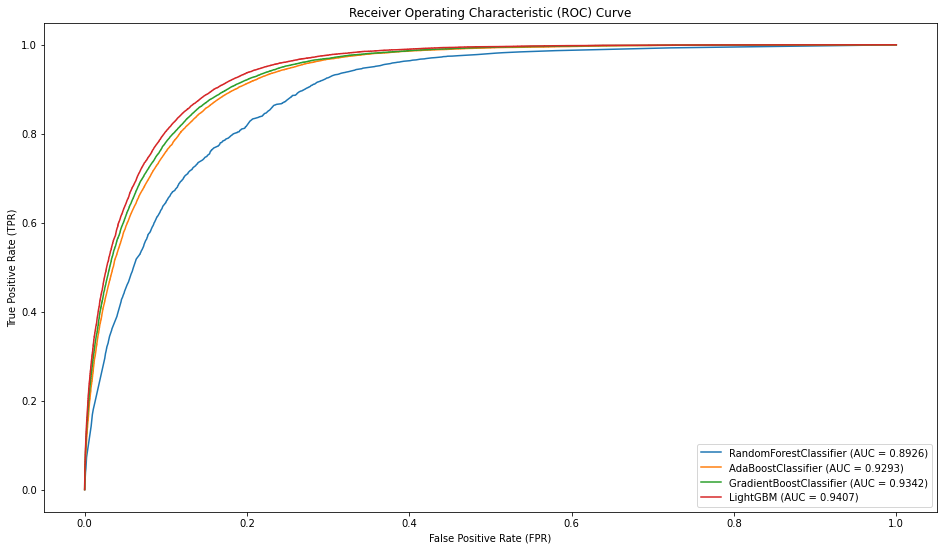

In [118]:
plt.figure(figsize=(16, 9))
for model, name in zip(models, ['RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostClassifier']):
    y_pred = model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(name ,roc_auc))
fpr, tpr, _ = roc_curve(y_test, lgb_pred)
roc_auc = roc_auc_score(y_test, lgb_pred)
plt.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format("LightGBM" ,roc_auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Submission

In [ ]:
predict_prob = lgb_clf.predict(df_test_scaled)#[:, 1].reshape(-1,1).flatten()
predict_prob

In [120]:
len(predict_prob)

924621

In [121]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': df_test.index, 'prediction': predict_prob})
output.to_csv('/kaggle/working/my_submission_7.zip', index = False, compression = 'zip')